In [17]:
experiment_name = 'knn_pretrain_angles_radius_base'
rad = 0.3
Ncorr = 10

# Colab settings

In [18]:
#Mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports and Settings

In [19]:
#Paths
import os
from pathlib import Path
#fp_repo = "/Users/roseline/Docs/UCL/Projects/B.Roads/B.Roads code/Fork/unsupervised-alignment-team-master"
fp_repo = '/content/gdrive/My Drive/unsupervised-alignment-team-master'
fp_intersect = fp_repo / Path('python','assets','intersect')
fp_save = fp_repo / Path('save')
os.chdir(fp_repo / Path('python'))

In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy as sp
from tqdm.notebook import tqdm
import pandas as pd
import uuid
import time
import itertools
#Custom modules
import embeddings as emb 
import utils 
import models
import losses
import train
import knn
#KERAS
import keras
import tensorflow as tf
#New
from scipy.spatial import distance
import scipy.interpolate as interpolate
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [21]:
def gpu_avail():
  is_avail = True
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    is_avail = False
  return is_avail  
print(gpu_avail())
# tf.debugging.set_log_device_placement(True)

True


# Parameters

In [27]:
#===PARAMETERS===\
override = False
sd = 56 #This should make the subsequend rd seed generation reproducible
tf.random.set_seed(sd)
np.random.seed(sd)
#=Synthetic data
n_systems = 2
n_concepts = 200
noise = 0.001
emb_dim = 2
n_epicentres = 1
linearsep = 1
#=Neural net
n_runs = 10
max_restart = 110 #10 last restarts to fine tune best
max_epoch = 30
batch_size = np.minimum(100, n_concepts) #64/100
#max_patience = 5
#=losses
gmm_scale = 0.01
loss_distr_scale = 1.0
loss_cycle_scale = 10000.0
#=Define models / optimizer/losses
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
#==SETUP=====
template_ceil = '    Ceiling\n    Accuracy 1: {0:.2f} 5: {1:.2f} 10: {2:.2f} Half: {3:.2f}\n'
template_loss = '    Epoch {0} Loss | total: {1:.5g} | cycle: {2:.3g} | f_dist: {3:.3g} | g_dist: {4:.3g}'
template_acc = '{0} = | 1: {1:.2f} | 5: {2:.2f} | 10: {3:.2f} | half: {4:.2f}'
template_res = '{0} = | f1: {1:.2f} | fhalf: {2:.2f} | g1: {3:.2f} | ghalf: {4:.2f} | total: {5:.2f} cycle: {6:.2f} | f_dist: {7:.2f} | g_dist: {8:.2f} '
n_batch = int(np.ceil(n_concepts / batch_size))
#==Set folders to save results and models===
fp_save_runs,fp_save_models = utils.create_save_folder(fp_save,override,n_systems,n_concepts,noise,emb_dim,
                                                 n_epicentres,linearsep,max_restart,max_epoch,batch_size,name = experiment_name)
print(fp_save_runs)
#===Get seed lists
sd_run_list = list(np.random.choice(10000, n_runs, replace=False))
#===Save params
experiment_id = uuid.uuid4()
dict_params = {'experiment_name':experiment_name,'experiment_id':experiment_id,'n_systems':n_systems,'n_concepts':n_concepts,'noise':noise,'emb_dim':emb_dim,'n_epicentres':n_epicentres,'linearsep':linearsep,
               'n_runs':n_runs,'max_restart':max_restart,'max_epoch':max_epoch,'batch_size':batch_size,'gmm_scale':gmm_scale,'loss_distr_scale':loss_distr_scale,
               'loss_cycle_scale':loss_cycle_scale,'lr':lr}
with open(str(fp_save_runs)+'/dict_params.pickle', 'wb') as handle:
  pickle.dump(dict_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
display(pd.DataFrame([dict_params]))

/content/gdrive/My Drive/unsupervised-alignment-team-master/save/knn_pretrain_angles_radius_base_2


,experiment_name,experiment_id,n_systems,n_concepts,noise,emb_dim,n_epicentres,linearsep,n_runs,max_restart,max_epoch,batch_size,gmm_scale,loss_distr_scale,loss_cycle_scale,lr
0,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,2,200,0.001,2,1,1,3,2,30,100,0.01,1.0,10000.0,0.001


# Prepare synthetic data

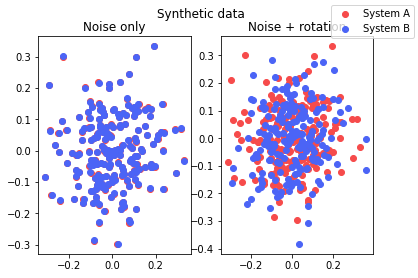

    Ceiling
    Accuracy 1: 1.00 5: 1.00 10: 1.00 Half: 1.00



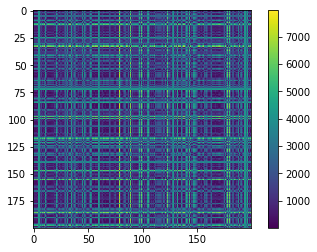

10 right over 10 tot
1.0
[[185   5   5]
 [  5 147 147]
 [117 194 194]
 [ 33 105 105]
 [ 72  79  79]
 [147 180 180]
 [ 46 125 125]
 [197 178 178]
 [ 53  29  29]
 [ 68  84  84]]
(10, 2) (10, 2)
Took : 4.13 s


In [28]:
A,B,X_A,X_B,B_shuff,B_idx_map = emb.get_data(n_systems,n_concepts,emb_dim,noise,n_epicentres,linearsep,sd,bplot=True)
# Determine ceiling performance.
acc_1, acc_5, acc_10, acc_half = utils.mapping_accuracy(X_A, X_B)
print(template_ceil.format(acc_1, acc_5, acc_10, acc_half))
#Print distance matrix local faetures
start = time.time()
D_XY = knn.get_DXY_angles(A,B_shuff,radius=rad,bplot = True)
X_pretrain,Y_pretrain, matches = knn.get_corres_data(A,B_shuff,D_XY,Ncorr)
acc , mat = knn.check_corresp(matches,B_idx_map)
print(acc)
print(mat)
print(X_pretrain.shape,Y_pretrain.shape)
end = time.time()
print("Took : %.2f s"%(end-start))

In [29]:
def pretrain(model_f,model_g,optimizer,x_pretrain, y_pretrain):
      with tf.GradientTape() as tape_pretrain_f:
        f_x = model_f(x_pretrain)
        corr_loss_f = tf.reduce_mean(tf.keras.losses.MSE(f_x, y_pretrain))
      gradients_pretrain_f = tape_pretrain_f.gradient(corr_loss_f, model_f.trainable_variables)
      with tf.GradientTape() as tape_pretrain_g:
        g_y = model_g(y_pretrain)
        corr_loss_g = tf.reduce_mean(tf.keras.losses.MSE(g_y, x_pretrain))
      gradients_pretrain_g = tape_pretrain_g.gradient(corr_loss_g, model_g.trainable_variables)
      # Combine gradients.
      optimizer.apply_gradients(zip(gradients_pretrain_f, model_f.trainable_variables))
      optimizer.apply_gradients(zip(gradients_pretrain_g, model_g.trainable_variables))
      return corr_loss_f, corr_loss_g

def train_batch_step(model_f,model_g,optimizer,x_batch, y_batch, loss_cycle_scale):
        with tf.GradientTape(persistent=True) as tape_cycle:
            x_c = model_g(model_f(x_batch))
            y_c = model_f(model_g(y_batch))
            cycle_loss = loss_cycle_scale * losses.flex_cycle_loss([x_batch,y_batch],[x_c,y_c], norm_type = 'l2')
        gradients_cycle_f = tape_cycle.gradient(cycle_loss, model_f.trainable_variables)
        gradients_cycle_g = tape_cycle.gradient(cycle_loss, model_g.trainable_variables)
        del tape_cycle
        optimizer.apply_gradients(zip(gradients_cycle_f, model_f.trainable_variables))
        optimizer.apply_gradients(zip(gradients_cycle_g, model_g.trainable_variables))
        return cycle_loss
    
def train_full_step(model_f,model_g,optimizer,x_all, y_all, loss_distr_scale,gmm_scale):
        k = 5
        beta = 0.1
        loss_knn_scale = 1
        with tf.GradientTape() as tape_f0:
            f_x = model_f(x_all)
            dist_loss_f = loss_distr_scale * losses.distribution_loss(y_all, f_x, gmm_scale)
            knn_loss_f = 0 #loss_knn_scale * knn_loss_calcX(y_all,f_x,k,beta)
            tot_loss_f = dist_loss_f + knn_loss_f
        gradients_target_fx = tape_f0.gradient(tot_loss_f, model_f.trainable_variables)
        with tf.GradientTape() as tape_g0:
            g_y = model_g(y_all)
            dist_loss_g = loss_distr_scale * losses.distribution_loss(x_all, g_y, gmm_scale)
            knn_loss_g = 0 #loss_knn_scale * knn_loss_calcX(x_all,g_y,k,beta)
            tot_loss_g = dist_loss_g + knn_loss_g
        gradients_target_gy = tape_g0.gradient(tot_loss_g, model_g.trainable_variables)
        # Combine gradients.
        optimizer.apply_gradients(zip(gradients_target_fx, model_f.trainable_variables))
        optimizer.apply_gradients(zip(gradients_target_gy, model_g.trainable_variables))
        return dist_loss_f, dist_loss_g , knn_loss_f , knn_loss_g

In [30]:
def train_models_one_restart(i_run,i_restart,sd_restart,x,y,y_idx_map,model_f,model_g,max_epoch,n_batch,x_0,x_1):
    #LOOP THROUGH EPOCHS
    epochs_dict_list = []
    for i_epoch in range(max_epoch):
        for x_batch, y_batch in utils.get_batch(x, y, batch_size):        
            #cycle_loss = train.train_batch_step(model_f,model_g,optimizer,x_batch, y_batch, loss_cycle_scale)
            cycle_loss = train_batch_step(model_f,model_g,optimizer,x_batch, y_batch, loss_cycle_scale)
        #dist_loss_f, dist_loss_g, knn_loss = train.train_full_step(model_f,model_g,optimizer,x, y,loss_distr_scale,gmm_scale)
        dist_loss_f, dist_loss_g, knn_loss_f , knn_loss_g = train_full_step(model_f,model_g,optimizer,x, y,loss_distr_scale,gmm_scale)
        knn_loss = knn_loss_f + knn_loss_g
        loss_total = dist_loss_f + dist_loss_g + cycle_loss + knn_loss
        # Project concept using current models
        f_x = model_f(x).numpy()
        g_y = model_g(y).numpy()
        #Get accuracies
        if y_idx_map is not None:
            acc_f1, acc_f5, acc_f10, acc_fhalf = utils.mapping_accuracy(f_x, y.numpy()[y_idx_map])
            acc_g1, acc_g5, acc_g10, acc_ghalf = utils.mapping_accuracy(g_y[y_idx_map], x.numpy())
        #Record all data in dict. 
        dict_entry = {'experiment_name':experiment_name,'experiment_id':experiment_id,'run':i_run,'restart':i_restart,'sd_restart':sd_restart,'epoch':i_epoch,'loss_total':loss_total.numpy(),
                      'cycle_loss':cycle_loss.numpy(),'dist_loss_f':dist_loss_f.numpy(),'dist_loss_g':dist_loss_g.numpy(),
                     'acc_f1':acc_f1, 'acc_f5':acc_f5, 'acc_f10':acc_f10, 'acc_fhalf':acc_fhalf,
                     'acc_g1':acc_g1, 'acc_g5':acc_g5, 'acc_g10':acc_g10, 'acc_ghalf':acc_ghalf}
        epochs_dict_list.append(dict_entry)
        #Print current results
        if i_epoch % max_epoch ==0 or i_epoch==max_epoch-1:
            print(template_res.format(i_epoch,acc_f1,acc_fhalf,acc_g1,acc_ghalf,loss_total,cycle_loss,dist_loss_f,dist_loss_g))
            #print('Epoch %d -'%i_epoch,template_acc.format('f(x)', acc_f1, acc_f5, acc_f10, acc_fhalf),template_acc.format('g(x)', acc_g1, acc_g5, acc_g10, acc_ghalf)) 
    #Plot final epoch
    #utils.plot_systems_results(x,y,f_x,g_y,x_0,x_1)
    return model_f,model_g,epochs_dict_list

======Run 0======
Seed :  4941


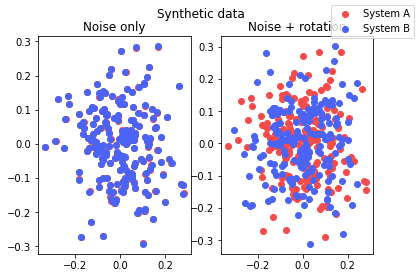

    Ceiling
    Accuracy 1: 0.99 5: 1.00 10: 1.00 Half: 1.00

    Threshold accuracy : 0.89
9 right over 10 tot


======Restart 0======
0 = | f1: 0.18 | fhalf: 1.00 | g1: 0.21 | ghalf: 1.00 | total: 10.48 cycle: 7.96 | f_dist: 1.85 | g_dist: 0.67 
29 = | f1: 0.98 | fhalf: 1.00 | g1: 0.99 | ghalf: 1.00 | total: 0.07 cycle: 0.04 | f_dist: 0.02 | g_dist: 0.02 
    Beat best model_f.
    Beat best model_g.
1 restarts necessary
======Restart 1======
0 = | f1: 0.96 | fhalf: 1.00 | g1: 0.94 | ghalf: 1.00 | total: 0.09 cycle: 0.05 | f_dist: 0.02 | g_dist: 0.02 
29 = | f1: 0.96 | fhalf: 1.00 | g1: 0.97 | ghalf: 1.00 | total: 0.09 cycle: 0.05 | f_dist: 0.02 | g_dist: 0.02 

======Run Summary======
None


,experiment_name,experiment_id,sd_run,last_restart,loss_total,cycle_loss,dist_loss_f,dist_loss_g,acc_f1,acc_f5,acc_f10,acc_fhalf,acc_g1,acc_g5,acc_g10,acc_ghalf,ceil_acc_1,ceil_acc_5,ceil_acc_10,ceil_acc_half,matches_acc,matches_mat
0,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,4941,0,0.090096,0.051765,0.020302,0.018029,0.965,1.0,1.0,1.0,0.975,1.0,1.0,1.0,0.99,1.0,1.0,1.0,0.9,"[[32, 112, 112], [99, 191, 191], [7, 72, 72], ..."


None
======Run 1======
Seed :  5927


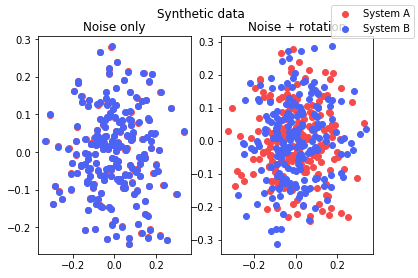

    Ceiling
    Accuracy 1: 0.97 5: 1.00 10: 1.00 Half: 1.00

    Threshold accuracy : 0.88
10 right over 10 tot


======Restart 0======
0 = | f1: 0.20 | fhalf: 1.00 | g1: 0.15 | ghalf: 1.00 | total: 111.29 cycle: 102.26 | f_dist: 4.34 | g_dist: 4.69 
29 = | f1: 0.98 | fhalf: 1.00 | g1: 0.98 | ghalf: 1.00 | total: 0.12 cycle: 0.06 | f_dist: 0.03 | g_dist: 0.03 
    Beat best model_f.
    Beat best model_g.
1 restarts necessary
======Restart 1======
0 = | f1: 0.86 | fhalf: 1.00 | g1: 0.89 | ghalf: 1.00 | total: 0.51 cycle: 0.42 | f_dist: 0.04 | g_dist: 0.05 
29 = | f1: 0.98 | fhalf: 1.00 | g1: 0.97 | ghalf: 1.00 | total: 0.10 cycle: 0.05 | f_dist: 0.02 | g_dist: 0.02 
    Beat best model_f.
    Beat best model_g.

======Run Summary======
None


,experiment_name,experiment_id,sd_run,last_restart,loss_total,cycle_loss,dist_loss_f,dist_loss_g,acc_f1,acc_f5,acc_f10,acc_fhalf,acc_g1,acc_g5,acc_g10,acc_ghalf,ceil_acc_1,ceil_acc_5,ceil_acc_10,ceil_acc_half,matches_acc,matches_mat
0,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,5927,0,0.09543,0.048006,0.024001,0.023422,0.985,1.0,1.0,1.0,0.975,1.0,1.0,1.0,0.975,1.0,1.0,1.0,1.0,"[[111, 193, 193], [53, 101, 101], [154, 171, 1..."


None
======Run 2======
Seed :  8947


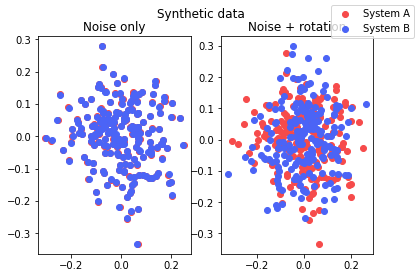

    Ceiling
    Accuracy 1: 0.98 5: 1.00 10: 1.00 Half: 1.00

    Threshold accuracy : 0.89
9 right over 10 tot


======Restart 0======
0 = | f1: 0.01 | fhalf: 1.00 | g1: 0.03 | ghalf: 1.00 | total: 152.81 cycle: 139.27 | f_dist: 6.82 | g_dist: 6.72 
29 = | f1: 0.98 | fhalf: 1.00 | g1: 0.98 | ghalf: 1.00 | total: 0.09 cycle: 0.05 | f_dist: 0.01 | g_dist: 0.02 
    Beat best model_f.
    Beat best model_g.
1 restarts necessary
======Restart 1======
0 = | f1: 0.96 | fhalf: 1.00 | g1: 0.98 | ghalf: 1.00 | total: 0.17 cycle: 0.13 | f_dist: 0.02 | g_dist: 0.02 
29 = | f1: 0.98 | fhalf: 1.00 | g1: 0.98 | ghalf: 1.00 | total: 0.07 cycle: 0.04 | f_dist: 0.01 | g_dist: 0.02 
    Beat best model_f.
    Beat best model_g.

======Run Summary======
None


,experiment_name,experiment_id,sd_run,last_restart,loss_total,cycle_loss,dist_loss_f,dist_loss_g,acc_f1,acc_f5,acc_f10,acc_fhalf,acc_g1,acc_g5,acc_g10,acc_ghalf,ceil_acc_1,ceil_acc_5,ceil_acc_10,ceil_acc_half,matches_acc,matches_mat
0,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,8947,0,0.067181,0.03646,0.012793,0.017929,0.98,1.0,1.0,1.0,0.985,1.0,1.0,1.0,0.985,1.0,1.0,1.0,0.9,"[[84, 149, 149], [95, 77, 77], [146, 70, 70], ..."


None
=======FINAL SUMMARY=====


,experiment_name,experiment_id,sd_run,last_restart,loss_total,cycle_loss,dist_loss_f,dist_loss_g,acc_f1,acc_f5,acc_f10,acc_fhalf,acc_g1,acc_g5,acc_g10,acc_ghalf,ceil_acc_1,ceil_acc_5,ceil_acc_10,ceil_acc_half,matches_acc,matches_mat
0,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,4941,0,0.090096,0.051765,0.020302,0.018029,0.965,1.0,1.0,1.0,0.975,1.0,1.0,1.0,0.990,1.0,1.0,1.0,0.9,"[[32, 112, 112], [99, 191, 191], [7, 72, 72], ..."
1,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,5927,0,0.095430,0.048006,0.024001,0.023422,0.985,1.0,1.0,1.0,0.975,1.0,1.0,1.0,0.975,1.0,1.0,1.0,1.0,"[[111, 193, 193], [53, 101, 101], [154, 171, 1..."
2,knn_pretrain_angles_radius_base,2d830142-5e6e-45c2-bf0a-d98c214c842b,8947,0,0.067181,0.036460,0.012793,0.017929,0.980,1.0,1.0,1.0,0.985,1.0,1.0,1.0,0.985,1.0,1.0,1.0,0.9,"[[84, 149, 149], [95, 77, 77], [146, 70, 70], ..."


In [31]:
all_res = []
summary_res = []
for i_run in range(n_runs):
    print('===============================')
    print('======Run {0}======'.format(i_run))
    print('===============================')
    sd_run = utils.set_seed_np_tf(sd_run_list[i_run])
    print("Seed : ", sd_run)
    sd_restart_list = list(np.random.choice(10000, max_restart, replace=False))
    run_folder = fp_save_models+'/run'+str(i_run)
    utils.create_folder(run_folder+ '/final') #Same as last restart
    #==Get data 
    A,B,X_A,X_B,B_shuff,B_idx_map = emb.get_data(n_systems,n_concepts,emb_dim,noise,n_epicentres,linearsep,sd_run,bplot=True)
    ceil_acc_1, ceil_acc_5, ceil_acc_10, ceil_acc_half = utils.mapping_accuracy(X_A, X_B)
    print(template_ceil.format(ceil_acc_1, ceil_acc_5, ceil_acc_10, ceil_acc_half))
    thresh_acc = ceil_acc_1 * 0.9
    print("    Threshold accuracy : %.2f" %thresh_acc )
    x, y , y_idx_map = A , B_shuff , B_idx_map
    x = tf.convert_to_tensor(x, dtype = np.float32())
    y = tf.convert_to_tensor(y, dtype = np.float32())
    #==PRETRAIN - Get data
    D_xy = knn.get_DXY_angles(x,y,radius=rad,bplot = False)
    x_pretrain, y_pretrain, matches = knn.get_corres_data(x,y,D_xy,Ncorr)
    matches_acc , matches_mat = knn.check_corresp(matches,y_idx_map)
    #Save data
    with open(str(run_folder)+'/x.pickle', 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(str(run_folder)+'/y.pickle', 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #print(x.shape,y.shape)
    #==Loop through restarts
    #=init best
    loss_best = np.inf
    best_model_f = models.MLP(emb_dim, emb_dim)
    best_model_g = models.MLP(emb_dim, emb_dim)
    dist_loss_g_best = np.inf
    dist_loss_f_best = np.inf
    #=Loop
    last_restarts = []
    restarts_dict_list = []
    acc_f1, acc_g1 = 0,0
    last_restart = -1
    for i_restart in tqdm(range(max_restart)):
        sd_restart = utils.set_seed_np_tf(sd_restart_list[i_restart])
        print('======Restart {0}======'.format(i_restart))
        #==init models
        thresh = 0 #if 0, always a new model except if use_best_model=True. 
        force_best_model = (i_restart>=max_restart-10) #if True, use best mode, else, random depends on thresh
        model_f,new_f = models.init_model(force_best_model,thresh,i_restart,sd_restart,emb_dim,best_model_f)
        model_g,new_g = models.init_model(force_best_model,thresh,i_restart,sd_restart,emb_dim,best_model_g)
        if new_f : print('    New model_f')
        if new_g : print('    New model_g')
        #==Pretrain
        for i_epoch in range(max_epoch):
          corr_loss_f, corr_loss_g = pretrain(model_f,model_g,optimizer,x_pretrain, y_pretrain)
        # f_x = model_f(x).numpy()
        # g_y = model_g(y).numpy()
        # acc_f1, acc_f5, acc_f10, acc_fhalf = utils.mapping_accuracy(f_x, y.numpy()[y_idx_map])
        # print("After pretraining...")
        # print(template_acc.format(-1,acc_f1,acc_f5,acc_f10,acc_fhalf))
        # utils.plot_systems_results(x,y,f_x,g_y,X_A,X_B)
        #==Train
        model_f,model_g,epochs_dict_list = train_models_one_restart(i_run,i_restart,sd_restart,
                                                                    x,y,y_idx_map,model_f,model_g,max_epoch,n_batch,X_A,X_B)
        #Get final losses and accuracies
        last_epoch_dict = epochs_dict_list[-1]
        loss_total, cycle_loss, dist_loss_f, dist_loss_g = utils.get_losses_from_dict(last_epoch_dict)
        acc_f1, acc_f5, acc_f10, acc_fhalf,acc_g1, acc_g5, acc_g10, acc_ghalf = utils.get_acc_from_dict(last_epoch_dict)
        #Save best model
        best_f,best_g = False,False
        if dist_loss_f < dist_loss_f_best:
                dist_loss_f_best = dist_loss_f
                best_model_f = model_f
                best_f = True
                print('    Beat best model_f.')
        if dist_loss_g < dist_loss_g_best:
            dist_loss_g_best = dist_loss_g
            best_model_g = model_g
            best_g = True
            print('    Beat best model_g.')  
        #Add and Store data
        for i in range(len(epochs_dict_list)):
            epochs_dict_list[i]['new_f']=new_f
            epochs_dict_list[i]['new_g']=new_g
            epochs_dict_list[i]['best_f']=best_f
            epochs_dict_list[i]['best_g']=best_g
        restarts_dict_list.append(epochs_dict_list)
        #====Save restart model
        restart_folder = run_folder + '/restart' + str(i_restart)
        utils.create_folder(restart_folder)
        utils.save_models(model_f,model_g,restart_folder)
        #====Breaking loop
        if (acc_f1>thresh_acc and acc_g1>thresh_acc) and last_restart==-1: #last_restart = -1 if this does not happen
            last_restart = i_restart
            print("%d restarts necessary" %(i_restart+1))
            #break
    if last_restart==-1: 
      last_restart = max_restart
    all_dict_entries = utils.flatten_list_of_list(restarts_dict_list) 
    all_res.append(all_dict_entries)
    #STORE FINAL RESULTS
    summary_dict = {'experiment_name':experiment_name,'experiment_id':experiment_id,'sd_run':sd_run,'last_restart': last_restart,'loss_total':loss_total,'cycle_loss':cycle_loss,
                    'dist_loss_f':dist_loss_f,'dist_loss_g':dist_loss_g,
                    'acc_f1':acc_f1, 'acc_f5':acc_f5, 'acc_f10':acc_f10, 'acc_fhalf':acc_fhalf,
                    'acc_g1':acc_g1, 'acc_g5':acc_g5, 'acc_g10':acc_g10, 'acc_ghalf':acc_ghalf,
                    'ceil_acc_1':ceil_acc_1, 'ceil_acc_5':ceil_acc_5, 'ceil_acc_10':ceil_acc_10, 'ceil_acc_half':ceil_acc_half,
                    'matches_acc':matches_acc,'matches_mat':matches_mat}
    summary_res.append(summary_dict)
    print(print('======Run Summary======'))
    print(display(pd.DataFrame([summary_dict])))
    #=====SAVE RUN MODEL====
    utils.save_models(model_f,model_g,run_folder+ '/final')
print('=========================')
print('=======FINAL SUMMARY=====')
print('=========================')
df_summary = pd.DataFrame(summary_res)
display(df_summary)
#Save results
with open(str(fp_save_runs)+'/all_res.pickle', 'wb') as handle:
    pickle.dump(all_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(str(fp_save_runs)+'/summary_res.pickle', 'wb') as handle:
    pickle.dump(summary_res, handle, protocol=pickle.HIGHEST_PROTOCOL)